In [48]:
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
import os
import json
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from utils import model_utils, file_utils
from utils.callbacks import EvalCallback

from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.preprocessor.preprocessors import data_split
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor, VecNormalize

from finrl.plot import backtest_stats

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
HYPERPARAMETERS_PATH = '..\TUNING\PETR4\DDPG_200_TECH_FUND'

In [50]:
env_kwargs = json.load(open(os.path.join(HYPERPARAMETERS_PATH, 'env_train_kwargs.json'), 'r'))
args = json.load(open(os.path.join(HYPERPARAMETERS_PATH, 'command_line_args.json'), 'r'))
print('ENV KWARGS')
print(env_kwargs, '\n')
print('ARGS')
print(args)

TEST_PATH = file_utils.uniquify(os.path.join('TESTS', '_'.join(args['tickers']), args['alg']))
os.makedirs(TEST_PATH, exist_ok=True)
os.makedirs(os.path.join(TEST_PATH, 'monitor_logs'), exist_ok=True)
os.makedirs(os.path.join(TEST_PATH, 'tb_log'), exist_ok=True)

ENV KWARGS
{'stock_dim': 1, 'hmax': 200, 'initial_amount': 100000, 'num_stock_shares': [0], 'buy_cost_pct': [0.001], 'sell_cost_pct': [0.001], 'reward_scaling': 1, 'state_space': 26, 'action_space': 1, 'tech_indicator_list': ['LPA', 'VPA', 'P/L', 'P/EBITDA', 'P/VPA', 'DL/PL', 'DL/EBITDA', 'ROE', 'MARGEM_EBITDA', 'DL/EBIT', 'MARGEM_EBIT', 'MARGEM_LIQUIDA', 'macd', 'boll_ub', 'boll_lb', 'rsi_30', 'stochrsi_30', 'wr_30', 'vwma_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma'], 'turbulence_threshold': None, 'print_verbosity': 1000} 

ARGS
{'alg': 'DDPG', 'tickers': ['PETR4.SA'], 'tuning_timesteps': 30000, 'train_timesteps': 200000, 'train_period': ['2017-01-01', '2018-12-31'], 'eval_period': ['2019-01-01', '2019-12-31'], 'trade_period': ['2020-01-01', '2021-12-31'], 'hmax': 200, 'use_ohlcv': False, 'initial_amount': 100000, 'n_trials': 10, 'n_repeats_by_trial': 3, 'output_path': 'DDPG_200_TECH_FUND', 'metric_to_optimize': 'Sortino ratio', 'n_eval_episodes': 1, 'use_best_model': True,

In [51]:
df_hyperparameters = pd.read_csv(os.path.join(HYPERPARAMETERS_PATH, 'hp_tuning_hist.csv'))
df_hyperparameters_group = df_hyperparameters.groupby(['trial', 'hyperparameters']).agg(['mean', 'std']).reset_index()
df_hyperparameters_group = df_hyperparameters_group.sort_values(('metric', 'mean'), ascending=False)

display(df_hyperparameters_group.head())

print('Best Trial: {} | Mean Metric: {:.4f} +- {:.4f}'.format(
    df_hyperparameters_group.iloc[0]['trial'][0], 
    df_hyperparameters_group.iloc[0][('metric', 'mean')],
    df_hyperparameters_group.iloc[0][('metric', 'std')],
    
    )
)

best_params = eval(df_hyperparameters_group.iloc[0]['hyperparameters'][0])
best_params = model_utils.load_params_from_store_format(best_params)

best_params

trial                                    hyperparameters    metric          
                                                                mean       std
7     7  {'gamma': 0.999, 'learning_starts': 2000, 'lea...  2.438286  0.863772
4     4  {'gamma': 0.99, 'learning_starts': 2000, 'lear...  2.398897  1.095956
5     5  {'gamma': 0.999, 'learning_starts': 2000, 'lea...  2.251037  0.789329
2     2  {'gamma': 0.98, 'learning_starts': 2000, 'lear...  2.218253  0.768788
3     3  {'gamma': 0.98, 'learning_starts': 2000, 'lear...  2.042108  0.904245

Best Trial: 7 | Mean Metric: 2.4383 +- 0.8638


{'gamma': 0.999,
 'learning_starts': 2000,
 'learning_rate': 7.997505872652796e-05,
 'batch_size': 128,
 'buffer_size': 1000000}

In [52]:
df = pd.read_pickle(os.path.join(HYPERPARAMETERS_PATH, 'dataset.pkl'))

train_set = data_split(df, args['train_period'][0], args['eval_period'][1])
eval_set = data_split(df, args['eval_period'][0], args['eval_period'][1])
trade_set = data_split(df, args['trade_period'][0], args['trade_period'][1])
# trade_set = data_split(df, '2021-01-01', '2021-12-31')

trade_set['date'] = pd.to_datetime(trade_set['date'])

print('Train\t', train_set['close'].iloc[-1] / train_set['close'].iloc[0] - 1)
print('Eval\t', eval_set['close'].iloc[-1] / eval_set['close'].iloc[0] - 1)
print('Trade\t', trade_set['close'].iloc[-1] / trade_set['close'].iloc[0] - 1)

Train	 1.0986820422927872
Eval	 0.29602925943984726
Trade	 0.14384820478065952


USANDO BEST MODEL
TIMESTEPS: 25220


,Model,Buy and Hold
Annual return,0.209199,0.072482
Cumulative returns,0.440284,0.143848
Annual volatility,0.380468,0.580281
Sharpe ratio,0.693850,0.424109
Calmar ratio,0.457005,0.114405
Stability,0.630000,0.398792
Max drawdown,-0.457761,-0.633560
Omega ratio,1.192130,1.089995
Sortino ratio,0.977114,0.567288
Skew,NaN,NaN


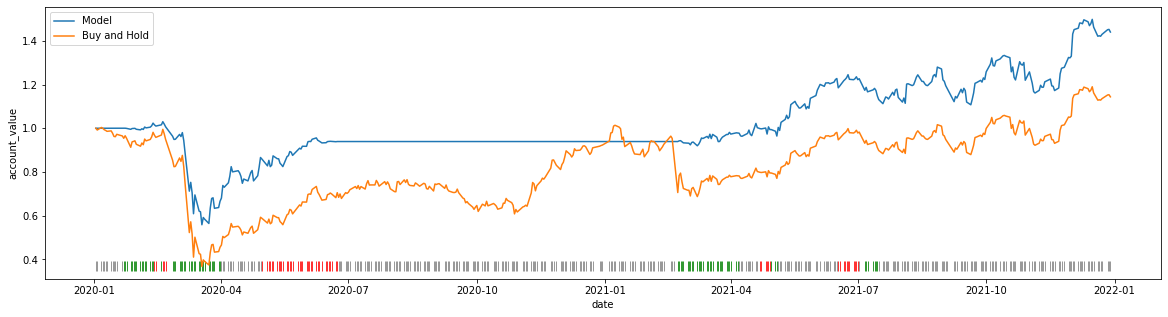

USANDO BEST MODEL
TIMESTEPS: 4850


,Model,Buy and Hold
Annual return,0.413470,0.072482
Cumulative returns,0.943773,0.143848
Annual volatility,0.346875,0.580281
Sharpe ratio,1.173987,0.424109
Calmar ratio,1.671229,0.114405
Stability,0.718306,0.398792
Max drawdown,-0.247405,-0.633560
Omega ratio,1.250147,1.089995
Sortino ratio,1.767220,0.567288
Skew,NaN,NaN


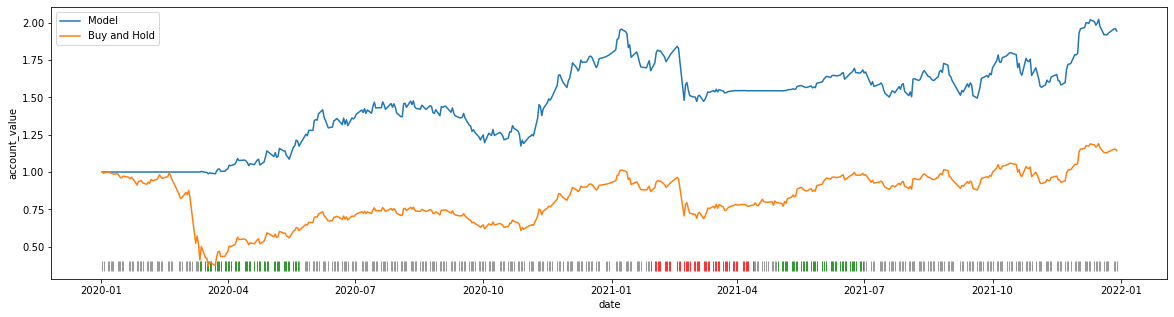

USANDO BEST MODEL
TIMESTEPS: 5335


,Model,Buy and Hold
Annual return,0.375969,0.072482
Cumulative returns,0.845936,0.143848
Annual volatility,0.309422,0.580281
Sharpe ratio,1.188517,0.424109
Calmar ratio,1.293486,0.114405
Stability,0.867326,0.398792
Max drawdown,-0.290663,-0.633560
Omega ratio,1.303918,1.089995
Sortino ratio,1.817176,0.567288
Skew,NaN,NaN


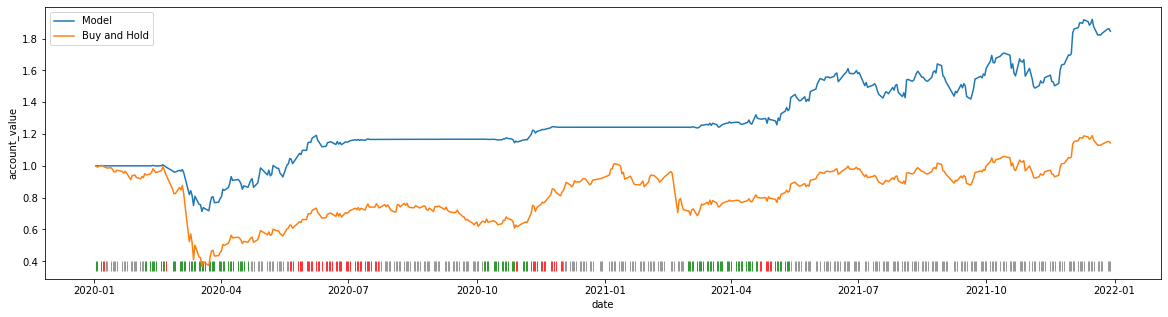

In [53]:
a = 7

MODEL_TYPE = 'best' # *'best' or 'final'

for b in range(0, 10):
    try:
        dataset = trade_set.copy() #data_split(trade_set, '2020-01-01', '2021-12-31').copy()
        dataset['date'] = pd.to_datetime(dataset['date'])

        e_eval_gym = StockTradingEnv(df=dataset, **env_kwargs)
        env_eval = DummyVecEnv([lambda: e_eval_gym])

        env_statistics_path = os.path.join(
            HYPERPARAMETERS_PATH, 
            'models',
            'TRIAL_{}_REPEAT_{}'.format(a, b),
            f'env_statistics_{MODEL_TYPE}'
        )

        env_eval = VecNormalize.load(
            env_statistics_path,
            env_eval,
        )
        env_eval.training = False
        env_eval.norm_reward = False

        best_model_path = os.path.join(
            HYPERPARAMETERS_PATH, 
            f'models',
            'TRIAL_{}_REPEAT_{}'.format(a, b),
            f'model_{MODEL_TYPE}.zip'
        )

        MODEL = model_utils.get_model(args['alg'])
        trained_model = MODEL.load(best_model_path, env_eval)

        print('USANDO BEST MODEL')
        print('TIMESTEPS:', trained_model.num_timesteps)


        account_memory, actions_memory, state_memory = model_utils.predict(
            trained_model, 
            env_eval, 
            True
        )

        account_temp = pd.DataFrame({
            'date': account_memory['date'],
            'account_value': dataset['close']
        })

        display(
            pd.concat([
                backtest_stats(account_value=account_memory),
                backtest_stats(account_value=account_temp)
            ], axis=1).rename(columns={0: 'Model', 1: 'Buy and Hold'})
        )

        cum_return_model = (account_memory['account_value'].pct_change(1)+1).cumprod().fillna(1)
        cum_return_beh = (dataset['close'].pct_change(1)+1).cumprod().fillna(1)

        actions_plot = np.where(
            actions_memory['actions'] > 0, 
            'green', 
            np.where(actions_memory['actions'] < 0,
                'red',
                'gray'
            )
        ).tolist() + ['gray']

        %matplotlib inline
        plt.figure(figsize=(20,5))
        sns.lineplot(x=dataset['date'], y=cum_return_model, label='Model')
        sns.lineplot(x=dataset['date'], y=cum_return_beh, label='Buy and Hold')

        sns.scatterplot(x=dataset['date'], y=min(cum_return_model.min(), cum_return_beh.min()), c=actions_plot, marker='|', s=100)
        plt.show()

    except Exception as e:
        break

## Retreino

In [55]:
from utils.file_utils import uniquify

In [56]:
def train_and_return_model(
    train_set,
    trade_set,
    env_kwargs,
    algorithm,
    train_episodes,
    model_params,
    best_model_path,
    return_best_model=False
):

    best_model_path = uniquify(best_model_path)

    os.makedirs(best_model_path, exist_ok=True)
    
    train_set = train_set.copy()

    e_train_gym = StockTradingEnv(
        df=train_set, 
        **env_kwargs
    )
    env_train = DummyVecEnv([lambda: e_train_gym])
    env_train = VecMonitor(
        env_train, 
        best_model_path
    )

    env_train = VecNormalize(
        env_train, 
        training=True,
        norm_obs=True, 
        norm_reward=True,
        gamma=model_params['gamma']
    )
    MODEL = model_utils.get_model(algorithm)
    model = MODEL(
        policy='MlpPolicy', 
        env=env_train,
        **model_params,
        verbose=False,
        seed=None,
        tensorboard_log=os.path.join(best_model_path)
    )

    eval_callback = EvalCallback(
        env_train, 
        n_eval_episodes=1,
        eval_freq=int(train_set.shape[0]),
        best_model_save_path=os.path.join(best_model_path),
        verbose=False
    )
    trained_model = model.learn(
        tb_log_name='retreino',
        log_interval=1,
        total_timesteps=train_set.shape[0] * train_episodes,
        callback=[eval_callback],
        reset_num_timesteps=True
    )

    if not return_best_model:
        return trained_model
    else:
        e_trade_gym = StockTradingEnv(df=trade_set, **env_kwargs)
        env_trade = DummyVecEnv([lambda: e_trade_gym])
        env_trade = VecNormalize.load(
            os.path.join(best_model_path, 'env_statistics_best'), env_trade
        )
        env_trade.training = False
        env_trade.norm_reward = False

        MODEL = model_utils.get_model(args['alg'])
        best_model = MODEL.load(
            os.path.join(best_model_path, 'model_best.zip'), env_trade
        )
        return best_model

In [57]:
def predict_and_evaluate(model, save_path=None):
    print('MODEL TIMESTEPS:', model.num_timesteps)

    account_memory, actions_memory, state_memory = model_utils.predict(
        model, model.env, True
    )

    account_temp = pd.DataFrame({
        'date': account_memory['date'],
        'account_value': dataset['close']
    })

    display(
        pd.concat([
            backtest_stats(account_value=account_memory),
            backtest_stats(account_value=account_temp)
        ], axis=1).rename(columns={0: 'Model', 1: 'Buy and Hold'})
    )

    cum_return_model = (account_memory['account_value'].pct_change(1)+1).cumprod().fillna(1)
    cum_return_beh = (dataset['close'].pct_change(1)+1).cumprod().fillna(1)

    actions_plot = np.where(
        actions_memory['actions'] > 0, 
        'green', 
        np.where(
            actions_memory['actions'] < 0,
            'red',
            'gray'
        )
    ).tolist() + ['gray']

    %matplotlib inline
    plt.figure(figsize=(20,5))
    sns.lineplot(x=dataset['date'], y=cum_return_model, label='Model')
    sns.lineplot(x=dataset['date'], y=cum_return_beh, label='Buy and Hold')

    sns.scatterplot(x=dataset['date'], y=min(cum_return_model.min(), cum_return_beh.min()), c=actions_plot, marker='|', s=100)
    
    if save_path is not None:
        plt.save(os.path.join(save_path, 'returns.png'))
    plt.show()

MODEL TIMESTEPS: 5089


,Model,Buy and Hold
Annual return,0.152177,0.072482
Cumulative returns,0.312671,0.143848
Annual volatility,0.560082,0.580281
Sharpe ratio,0.545053,0.424109
Calmar ratio,0.243859,0.114405
Stability,0.520801,0.398792
Max drawdown,-0.624037,-0.633560
Omega ratio,1.118096,1.089995
Sortino ratio,0.737850,0.567288
Skew,NaN,NaN


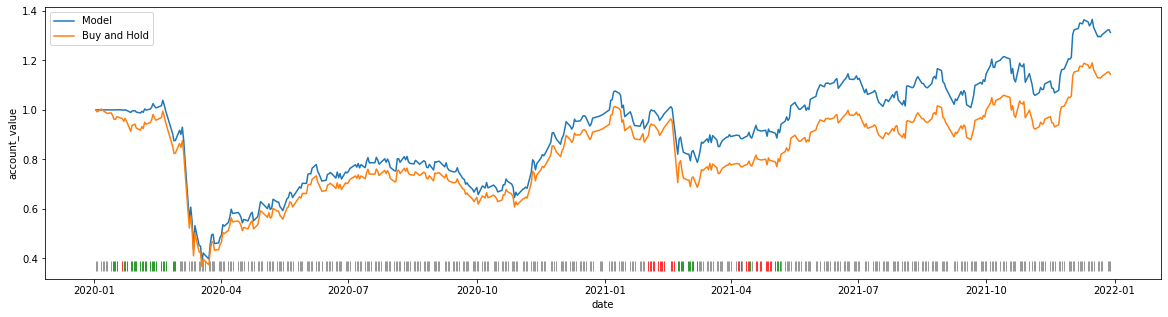

MODEL TIMESTEPS: 6543


,Model,Buy and Hold
Annual return,0.045459,0.072482
Cumulative returns,0.089136,0.143848
Annual volatility,0.543515,0.580281
Sharpe ratio,0.365938,0.424109
Calmar ratio,0.072111,0.114405
Stability,0.330206,0.398792
Max drawdown,-0.630411,-0.633560
Omega ratio,1.083417,1.089995
Sortino ratio,0.487742,0.567288
Skew,NaN,NaN


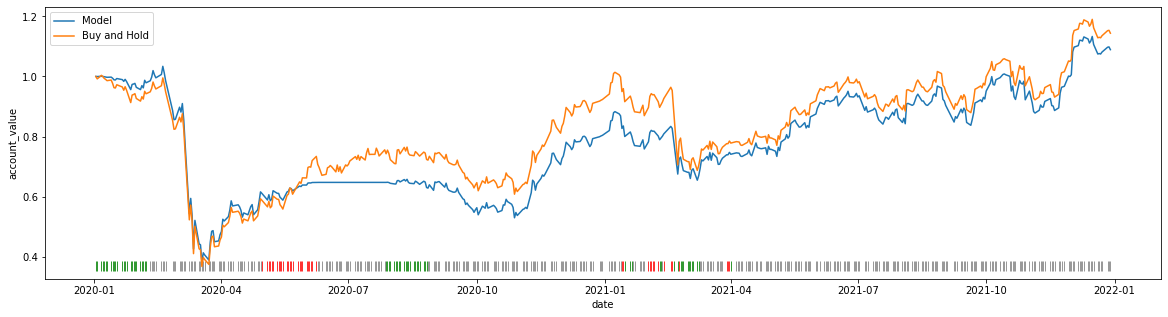

MODEL TIMESTEPS: 7270


,Model,Buy and Hold
Annual return,0.281778,0.072482
Cumulative returns,0.610903,0.143848
Annual volatility,0.258893,0.580281
Sharpe ratio,1.090045,0.424109
Calmar ratio,1.515875,0.114405
Stability,0.779020,0.398792
Max drawdown,-0.185885,-0.633560
Omega ratio,1.301191,1.089995
Sortino ratio,1.681346,0.567288
Skew,NaN,NaN


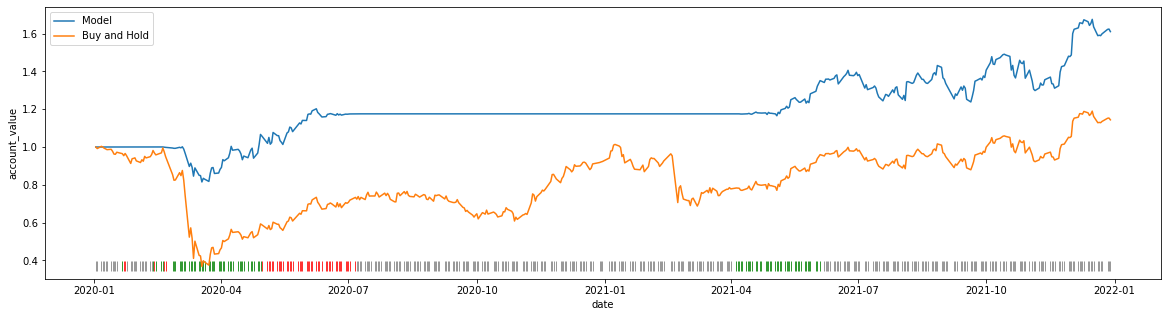

MODEL TIMESTEPS: 5089


c:\Users\edyalenquer\.conda\envs\rl_study\lib\site-packages\empyrical\stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


,Model,Buy and Hold
Annual return,-0.002499,0.072482
Cumulative returns,-0.004794,0.143848
Annual volatility,0.001994,0.580281
Sharpe ratio,-1.256131,0.424109
Calmar ratio,-0.473366,0.114405
Stability,0.081108,0.398792
Max drawdown,-0.005279,-0.633560
Omega ratio,0.279003,1.089995
Sortino ratio,-1.390447,0.567288
Skew,NaN,NaN


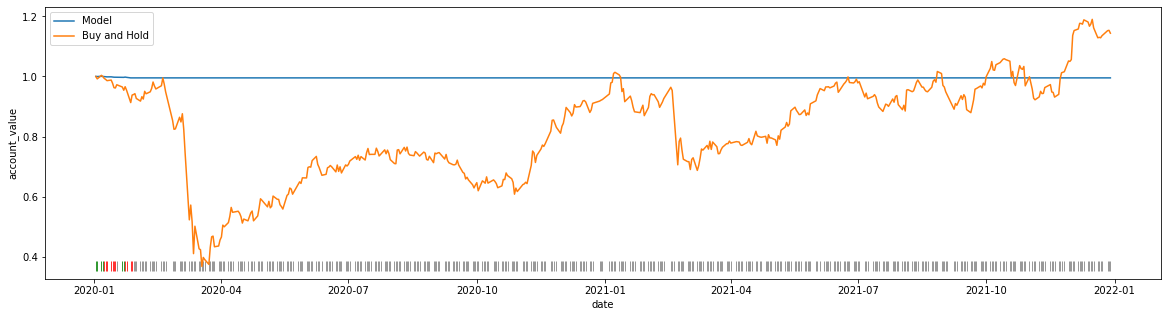

MODEL TIMESTEPS: 5089


,Model,Buy and Hold
Annual return,0.188035,0.072482
Cumulative returns,0.392257,0.143848
Annual volatility,0.499929,0.580281
Sharpe ratio,0.603790,0.424109
Calmar ratio,0.323021,0.114405
Stability,0.591410,0.398792
Max drawdown,-0.582112,-0.633560
Omega ratio,1.150995,1.089995
Sortino ratio,0.828503,0.567288
Skew,NaN,NaN


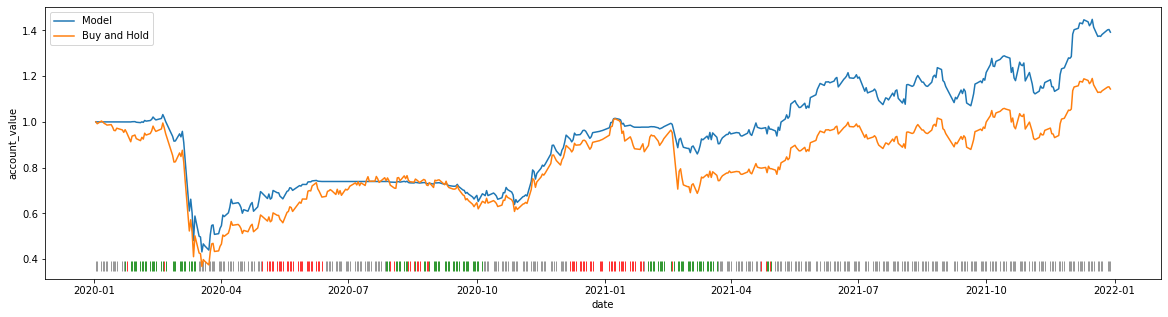

In [58]:
for i in range(5):
    model = train_and_return_model(
        train_set=train_set,
        trade_set=trade_set,
        env_kwargs=env_kwargs,
        algorithm=args['alg'],
        train_episodes=10,
        model_params=best_params,
        return_best_model=True,
        best_model_path=os.path.join(
            '..',
            'retrain_and_evaluation',
            f'retrain_folder_{i}'
        )
    )

    predict_and_evaluate(model)



MODEL TIMESTEPS: 64703


,Model,Buy and Hold
Annual return,0.459025,0.072482
Cumulative returns,1.065878,0.143848
Annual volatility,0.241232,0.580281
Sharpe ratio,1.689949,0.424109
Calmar ratio,3.405923,0.114405
Stability,0.900263,0.398792
Max drawdown,-0.134773,-0.633560
Omega ratio,1.460740,1.089995
Sortino ratio,2.766948,0.567288
Skew,NaN,NaN


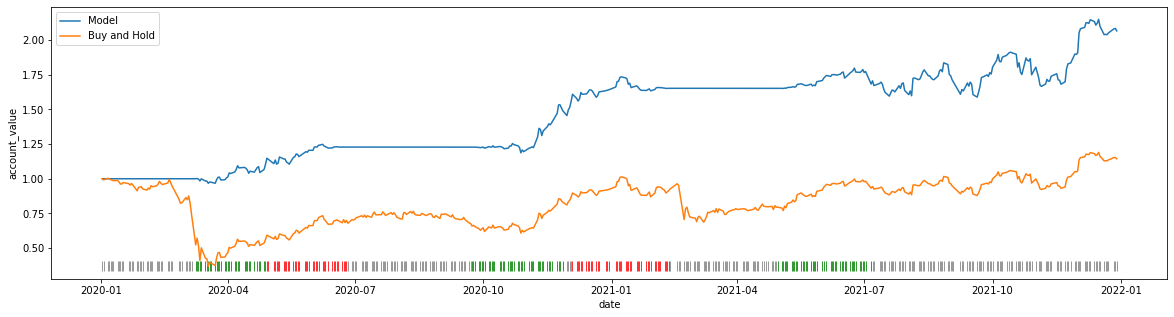

In [59]:
for i in range(5):
    model = train_and_return_model(
        train_set=train_set,
        trade_set=trade_set,
        env_kwargs=env_kwargs,
        algorithm=args['alg'],
        train_episodes=100,
        model_params=best_params,
        return_best_model=True,
        best_model_path=os.path.join(
            '..',
            'retrain_and_evaluation_2',
            f'retrain_folder_{i}'
        )
    )

    predict_and_evaluate(model)

In [25]:
e_train_gym = StockTradingEnv(
    df=train_set, 
    **env_kwargs
)
env_train = DummyVecEnv([lambda: e_train_gym])
env_train = VecMonitor(
    env_train, 
    os.path.join('.')
)

env_train = VecNormalize(
    env_train, 
    training=True,
    norm_obs=True, 
    norm_reward=True,
    gamma=best_params['gamma']
)
MODEL = model_utils.get_model(args['alg'])
model = MODEL(
    policy='MlpPolicy', 
    env=env_train,
    **best_params,
    verbose=True,
    seed=None,
    tensorboard_log=os.path.join('.')
)

eval_callback = EvalCallback(
    env_train, 
    n_eval_episodes=1,
    eval_freq=int(train_set.shape[0]/len(args['tickers'])),
    best_model_save_path=os.path.join('.'),
    verbose=False
)
trained_model = model.learn(
    tb_log_name='retreino',
    log_interval=1,
    total_timesteps=train_set.shape[0] * 10,
    callback=[eval_callback],
    reset_num_timesteps=True
)

Using cuda device
Logging to .\retreino_8
---------------------------------
| eval/              |          |
|    mean_reward     | 0        |
| time/              |          |
|    total_timesteps | 727      |
---------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 727       |
|    ep_rew_mean     | 6922.8413 |
| time/              |           |
|    episodes        | 1         |
|    fps             | 208       |
|    time_elapsed    | 3         |
|    total_timesteps | 727       |
----------------------------------
---------------------------------
| eval/              |          |
|    mean_reward     | 0        |
| time/              |          |
|    total_timesteps | 1454     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 727      |
|    ep_rew_mean     | 5334.251 |
| time/              |          |
|    episodes        | 2      

USANDO BEST MODEL
TIMESTEPS: 36350


,Model,Buy and Hold
Annual return,-0.010201,0.072482
Cumulative returns,-0.019501,0.143848
Annual volatility,0.485199,0.580281
Sharpe ratio,0.234383,0.424109
Calmar ratio,-0.016325,0.114405
Stability,0.148011,0.398792
Max drawdown,-0.624911,-0.633561
Omega ratio,1.067882,1.089995
Sortino ratio,0.307731,0.567288
Skew,NaN,NaN


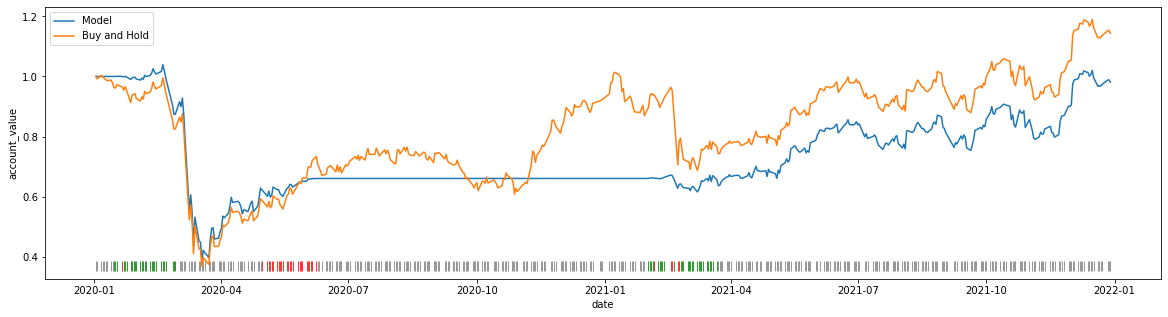

In [26]:
dataset = trade_set.copy()

e_eval_gym = StockTradingEnv(df=dataset, **env_kwargs)
env_eval = DummyVecEnv([lambda: e_eval_gym])
env_eval = VecNormalize.load(os.path.join('.', 'env_statistics_best'), env_eval)

env_eval.training = False
env_eval.norm_reward = False

MODEL = model_utils.get_model(args['alg'])
best_model = MODEL.load(os.path.join('.', 'model_best.zip'), env_eval)

print('USANDO BEST MODEL')
print('MODEL TIMESTEPS:', best_model.num_timesteps)

account_memory, actions_memory, state_memory = model_utils.predict(
    best_model, 
    env_eval, 
    True
)

account_temp = pd.DataFrame({
    'date': account_memory['date'],
    'account_value': dataset['close']
})

display(
    pd.concat([
        backtest_stats(account_value=account_memory),
        backtest_stats(account_value=account_temp)
    ], axis=1).rename(columns={0: 'Model', 1: 'Buy and Hold'})
)

cum_return_model = (account_memory['account_value'].pct_change(1)+1).cumprod().fillna(1)
cum_return_beh = (dataset['close'].pct_change(1)+1).cumprod().fillna(1)

actions_plot = np.where(
    actions_memory['actions'] > 0, 
    'green', 
    np.where(
        actions_memory['actions'] < 0,
        'red',
        'gray'
    )
).tolist() + ['gray']

%matplotlib inline
plt.figure(figsize=(20,5))
sns.lineplot(x=dataset['date'], y=cum_return_model, label='Model')
sns.lineplot(x=dataset['date'], y=cum_return_beh, label='Buy and Hold')

sns.scatterplot(x=dataset['date'], y=min(cum_return_model.min(), cum_return_beh.min()), c=actions_plot, marker='|', s=100)
plt.show()
